In [2]:
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [3]:
from dotenv import load_dotenv
import os
load_dotenv()
os.getenv

<function os.getenv(key, default=None)>

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    max_tokens=1000,
    streaming=True,
)

In [5]:
from langchain_community.tools.openweathermap.tool import OpenWeatherMapQueryRun
from langchain_community.utilities.openweathermap import OpenWeatherMapAPIWrapper
from langchain_tavily import TavilySearch
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.utilities.arxiv import ArxivAPIWrapper  # Searches for academic papers.
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper






weather_tool = OpenWeatherMapQueryRun(api_wrapper=OpenWeatherMapAPIWrapper())
tavily_tool = TavilySearch()
arxiv_tool = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
tools = [weather_tool,tavily_tool,arxiv_tool,wiki_tool]

In [6]:
llm_with_tools = llm.bind_tools(tools)

In [7]:
class state(TypedDict):
    messages: Annotated[list,add_messages]

graph_builder = StateGraph(state)

In [8]:
def Biva(state):
   return {"messages": [llm_with_tools.invoke(state["messages"])]}  

graph_builder.add_node("Biva",Biva)
graph_builder.add_node("tools",ToolNode(tools))
graph_builder.add_edge(START, "Biva")
graph_builder.add_conditional_edges("Biva",tools_condition)
graph_builder.add_edge("tools","Biva")
graph_builder.add_edge("Biva", END)
graph = graph_builder.compile()

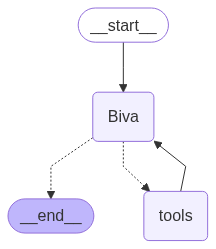

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

The chatbot can now use tools to answer user questions, but it does not remember the context of previous interactions


LangGraph solves this problem through persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.


checkpointing is much more powerful than simple chat memory 

This is in-memory checkpointer, which is convenient for the tutorial. However, in a production application, you would likely change this to use SqliteSaver or PostgresSaver and connect a database.

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [11]:
graph = graph_builder.compile(checkpointer=memory)

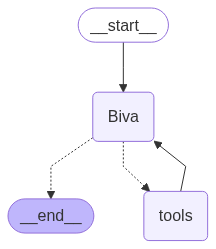

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

 your graph is compiled with a checkpointer, and every time you run a checkpoint‑enabled graph LangGraph expects you to tell it which **“thread” (conversation)** this run belongs to. You do that by supplying a tiny config dict that contains at least a thread_id.

In [14]:
#Pick a thread to use as the key for this conversation.
run_cfg = {"configurable": {"thread_id": "1"}}

messages = graph.invoke(
    {"messages": [{"role": "user", "content": "Who is the Prime Minister of India?"}]},
    config=run_cfg  
)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Who is the Prime Minister of India?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_sY9Qv2R6vZnIEqUoJ4r4YiUZ)
 Call ID: call_sY9Qv2R6vZnIEqUoJ4r4YiUZ
  Args:
    query: Prime Minister of India
================================= Tool Message =================================
Name: wikipedia

Page: Prime Minister of India
Summary: The prime minister of India (ISO: Bhārata kē Pradhānamantrī) is the head of government of the Republic of India. Executive authority is vested in the prime minister and his chosen Council of Ministers, despite the president of India being the nominal head of the executive.  The prime minister has to be a member of one of the houses of bicameral Parliament of India, alongside heading the respective house. The prime minister and the cabinet are at all times responsible to the Lok Sabha.
The prime minister is appointed by 

In [15]:
messages = graph.invoke(
    {"messages": [{"role": "user", "content": "What is his current age now?"}]},
    config=run_cfg  
)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Who is the Prime Minister of India?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_sY9Qv2R6vZnIEqUoJ4r4YiUZ)
 Call ID: call_sY9Qv2R6vZnIEqUoJ4r4YiUZ
  Args:
    query: Prime Minister of India
================================= Tool Message =================================
Name: wikipedia

Page: Prime Minister of India
Summary: The prime minister of India (ISO: Bhārata kē Pradhānamantrī) is the head of government of the Republic of India. Executive authority is vested in the prime minister and his chosen Council of Ministers, despite the president of India being the nominal head of the executive.  The prime minister has to be a member of one of the houses of bicameral Parliament of India, alongside heading the respective house. The prime minister and the cabinet are at all times responsible to the Lok Sabha.
The prime minister is appointed by 